**Previous book**: <a href='./02_column_refactor.ipynb'>[Column Refactoring]</a>

## Part 3: Subsetting

**Note**: This notebook expects <code>stage2_refactored.csv</code> from the <code>02_column_refactor.ipynb</code> notebook!

The original dataset contains information about a wide range of productions such as TV specials, movies and serials. However, best practices dicate that a table should represent only one entity or topic. Therefore in this stage, we will narrow our focus to serials. First, we will identify which entries are serials, then subset these entries and check if each row can be uniquely identified. 

**Input:** <code>/data/interim/stage2_refactored.csv</code>
<br>
**Output:** <code>/data/interim/stage3_serials.csv</code> and <code>/data/final/episodes_data.csv</code>
### Initial imports
We start by importing the CSV file created in part 2:

In [1]:
import numpy as np
import pandas as pd

# start_year acts more like a label than a true integer
df = pd.read_csv("../data/interim/stage2_refactored.csv",
                 dtype={"start_year": "str", "votes": "Int64","run_time": "Int64"})
df.head()

,title,start_year,end_year,genre,summary,rating,votes,run_time,gross,production_type,actors,director
0,Blood Red Sky,2021,NaN,"Action, Horror, Thriller",A woman with a mysterious illness is forced in...,6.1,21062,121,NaN,NaN,"Peri Baumeister, Carl Anton Koch, Alexander Sc...",Peter Thorwarth
1,Masters of the Universe: Revelation,2021,Ongoing,"Animation, Action, Adventure",The war for Eternia begins again in what may b...,5.0,17870,25,NaN,NaN,"Chris Wood, Sarah Michelle Gellar, Lena Headey...",NaN
2,The Walking Dead,2010,2022,"Drama, Horror, Thriller",Sheriff Deputy Rick Grimes wakes up from a com...,8.2,885805,44,NaN,NaN,"Andrew Lincoln, Norman Reedus, Melissa McBride...",NaN
3,Rick and Morty,2013,Ongoing,"Animation, Adventure, Comedy",An animated series that follows the exploits o...,9.2,414849,23,NaN,NaN,"Justin Roiland, Chris Parnell, Spencer Grammer...",NaN
4,Army of Thieves,2021,NaN,"Action, Crime, Horror","A prequel, set before the events of Army of th...",NaN,<NA>,<NA>,NaN,NaN,"Matthias Schweighöfer, Nathalie Emmanuel, Ruby...",Matthias Schweighöfer


While the intial stages were focused on cleaning the data while retaining its original information, the next stages build on the original data by focusing the dataset. We start with the <code>production_type</code> column.

### production_type
The <code>production_type</code> column was created from the now defunct <code>YEAR</code> column.
It is likely to be missing a lot of values. Check the column for missing values:

In [2]:
df["production_type"].isna().sum()

8531

The majority of values are missing for this column. What values are present?

In [3]:
df["production_type"].value_counts()

production_type
TV Special    397
I             189
TV Movie      161
Video         112
II             95
III            35
IV             12
TV Short        8
VII             7
V               6
VI              5
XI              2
XII             1
VIII            1
XXIII           1
XLI             1
IX              1
XIV             1
XIII            1
Video Game      1
Name: count, dtype: int64

A lot of entries have Roman numerals as the production type. The reason for this is not clear, and they may just be a result of how the data were scraped.
</p>
Building from the data already present, productions in this dataset can be separated into three main categories:
<ol>
    <li><b>Serial</b> - multiple episodes released over a period of time.</li> 
    <li><b>Film</b> - a stand-alone long-form release (includes TV movies).</li>
    <li><b>One-off feature</b> - a stand-alone release. Includes two types:</li>
        <ul>
            <li>Television special - a TV show made for a specific occassion, live music or comedy performances</li>
            <li>Short - a short-form (usually a few minutes to half an hour) television program usually dealing with a single story or idea</li>
        </ul>
</ol>
Each of these production types vary in different ways, so the type can be inferred. It makes sense to have three different tables each concerning a different production type.

The easiest case is the first case, serials. By definition, a serial runs over a period of time. Any production that has an end date is likely a serial, and can be labeled as such. The main focus for the rest of this project will be serial. The other production types may be revisited as an extension exercise.

In [4]:
df.loc[~df["end_year"].isnull(), "production_type"] = "Serial"

<b>NOTE</b>
</br>
There are two important things to mention about this approach.
<ol>
<li>This is not a comprehensive way of identifying every serial in the dataset. It is possible for a record to be missing entries for both <code>start_year</code> and <code>end_year</code>. Any serials with missing years will not be labelled correctly</li>
<li>Any previous value for <code>production_type</code> will be overwritten, so it is necessary to check the value counts after making the change for unintended consequences</li>
</ol>

In [5]:
df["production_type"].value_counts()

production_type
Serial        4282
TV Special     397
I              174
TV Movie       161
Video          112
II              84
III             35
IV              12
TV Short         8
VII              7
V                6
VI               5
XI               2
XII              1
VIII             1
XXIII            1
XLI              1
IX               1
XIV              1
XIII             1
Video Game       1
Name: count, dtype: int64

The operation only changed a few records with Roman numerals to <code>Serial</code>, and did not make any unwanted changes.
</p>
This also shows that a large number of entries in this dataset (4282 out of 9568) are related to serials.

### Serials dataset
Despite the name <code>MOVIES</code>, a large portion of the original dataset describes serials. The characteristics of serials have some overlap with those of a film, but some features that are relevant to films are not relevant to serials. Therefore, it would make more sense to separate serials from the rest of the productions.
</p>
Create a separate data frame containing only information about serials:

In [6]:
df_serials = df.loc[df["production_type"] == "Serial", :]

Examine characteristics of productions labelled as <code>Serials</code>:

In [7]:
df_serials.describe()

,rating,votes,run_time,gross
count,3794.000000,3794.0,2876.0,0.0
mean,7.415999,10883.643121,39.269471,NaN
std,1.040138,56113.93993,29.580547,NaN
min,1.100000,5.0,1.0,NaN
25%,6.900000,97.0,24.0,NaN
50%,7.500000,398.5,38.0,NaN
75%,8.100000,2133.75,47.0,NaN
max,9.900000,1552311.0,853.0,NaN


Compare to the records in the original data set that are not labelled as <code>Serials</code>:

In [8]:
df[~df.index.isin(df_serials.index)].describe()

,rating,votes,run_time,gross
count,4374.000000,4374.0,4132.0,460.000000
mean,6.489209,18840.200046,89.479913,43.701870
std,1.200889,80104.371877,46.342847,82.423304
min,1.800000,5.0,1.0,0.000000
25%,5.800000,312.0,64.0,0.150000
50%,6.600000,1381.0,90.0,6.145000
75%,7.400000,5662.75,105.0,46.947500
max,9.400000,1713028.0,573.0,504.010000


Compared to non-serials, serials are rated higher, but with fewer votes. Serials also do not have a gross. This is to be expected because gross (revenue generated by ticket sales) is only relevant to films with theatrical releases. Therefore this column can be dropped from the TV serials dataset without losing any data:

In [9]:
df_serials = df_serials.drop("gross", axis=1)

All rows of the serials dataframe are serials, so <code>production_type</code> is now redundant in this dataset:

In [10]:
df_serials = df_serials.drop("production_type", axis=1)

#### Uniqueness

Is title alone enough to uniquely indentify each production or do some productions share the same name? First, count the number of unique titles in the serials dataset:

In [11]:
len(df_serials["title"].unique())

1763

The title is enough to identify 1763 of the 4282 records. Can more titles be identified by also using the start year?

In [12]:
len((df_serials["title"] + df_serials["start_year"]).unique())

1769

There are 6 more titles when including the start year. This means that 6 titles share the same name but started in different years. Does including the end year identify even more?

In [13]:
len((df_serials["title"] + df_serials["start_year"] + df_serials["end_year"]).unique())

1769

Including the end year did not identify any new results. Because a serial is defined as any entry with an end date (either an actual year or 'ongoing'), its impossible for any of these entries to be missing this information. Therefore there are 1769 unique TV serials in the dataset.
<p>
What are the titles that share the same name?

In [14]:
grouped_unique = df_serials.groupby("title").agg({"start_year": "nunique", "end_year": "nunique"})
grouped_unique[(grouped_unique["start_year"] > 1) | (grouped_unique["end_year"] > 1)]

,start_year,end_year
title,,
Heartbreak High,2,2
Kakegurui,2,2
Kingdom,3,2
Sexy Beasts,2,1
Undercover,2,1


From the table above, we can see that there are 6 television serials that share the same title (<i>Kingdom</i> is shared by 3 separate serials). Some of these are newer remakes of older titles, others simply share the same name. However, when taking into account <code>start_year</code>, they can all be distinguished. Therefore, it is important to include the year when specifying a title.

### Episodes
If there are only 1769 unique titles, then why do we have 4282 entries in the dataset?

First, count how many entries we have for each serial:

In [15]:
grouped_titles = df_serials.groupby(["title", "start_year"])

In [16]:
grouped_titles.agg(
    {"end_year": "count"}
        ).sort_values(
            by="end_year", ascending=False
                ).rename({"end_year": "entries"}, axis=1).head(10)

,,entries
title,start_year,
Bleach: Burîchi,2004,66
Avatar: The Last Airbender,2005,62
La Reina de Indias y el Conquistador,2020,61
Dexter,2006,49
The Drew Barrymore Show,2020,45
Power Rangers Beast Morphers,2019,41
Johnny Test,2005,40
She-Ra and the Princesses of Power,2018,39
The Boondocks,2005,31


From the table above, we can see that there are a lot of different entries for some shows each with it's own plot summary or rating.

Examine one of these shows to find out why:

In [17]:
df_serials[df_serials["title"] == "Johnny Test"]["summary"].head()

1110    The adventures of average suburban boy Johnny ...
6496    Susan and Mary split Dad's bowling ball in hal...
6497    The Ice Pigs hockey team are big losers, so Jo...
6498    After Johnny agrees to test out their new Full...
6499    Things mysteriously disappear underground and ...
Name: summary, dtype: object

Consulting the original source of the data, IMDb, we can see that the first entry (1110) refers to the <a href='https://www.imdb.com/title/tt0454349'>Johnny Test</a> show, while the second entry (much later at 6498) refers to <a href='https://www.imdb.com/title/tt0616806/'>an individual episode</a> of Johnny Test. Therefore, it is fair to assume that the first entry refers to the show in general, and the subsequent entries refer to individual episodes of that show.

**Note**: not all the episodes are included. For example, on Wikipedia, there are 96 episodes of <i>Dexter</i>, but in this dataset, there are only 48. We are also missing important information such as the name of each episode. This makes it difficult to know which episodes are missing, so this information is of limited use.

In the interest of making a dataset about one topic (serials), it makes sense to separate individual episodes from serials in general. Because Pandas defaults to keeping only the first entry, we can capture all the episodes by selecting entries with duplicated title and start year:


In [18]:
df_episodes = df_serials[df_serials.duplicated(subset=["title", "start_year"])]

There is a one-to-many relationship between serials and episodes. Each serial may contain multiple episodes, and each episode belongs to a single serial. We can modify the structure of the episode dataframe to be more suitable:

In [19]:
# end_year and genre is the same for every episode and is stored on a per serial basis
df_episodes = df_episodes.drop(["end_year", "genre"], axis=1)
# rename columns to be specific to an episode
df_episodes = df_episodes.rename({"title": "show", "start_year": "year", "plot_summary": "episode_description"}, axis=1)

With the episode information safely stored in a new dataframe, we can safely drop it from the serial dataframe:

In [20]:
df_serials = df_serials.drop_duplicates(subset=["title", "start_year"])

### Modifying serials
Now that the serial dataframe only contains serials, re-examine for missing values:

In [21]:
df_serials.isna().sum()

title            0
start_year       0
end_year         0
genre            7
summary         62
rating         150
votes          150
run_time       509
actors          84
director      1762
dtype: int64

The <code>director</code> column is missing almost all of its values. This makes sense because TV shows tend to have a creator, while each individual episode may have a different a director.

We can safely drop this column:

In [22]:
df_serials = df_serials.drop("director", axis=1)

#### Runtime
Next, we can revisit <code>run_time</code>. As shown in Part 1, a lot of values in this column are extremely high. Re-examine the values now that serials have been isolated:

In [23]:
df_serials["run_time"].describe()

count       1260.0
mean      42.79127
std      41.972779
min            1.0
25%           24.0
50%           40.0
75%           50.0
max          853.0
Name: run_time, dtype: Float64

This column now looks even more skewed than it did previously. One standard deviation is about the same as the mean, 25% of the data is above 50 minutes and the maximum value is 853 minutes. As stated before, the extreme values are likely measuring the total run time of a serial across all of its episodes rather than the average run time of a single episode.

Although possible, it seems unlikely that many serials would have episodes that exceed the 90 minute mark. We will take this as the upper limit:

In [24]:
df_serials.loc[df_serials["run_time"] > 90, "run_time"] = np.nan

Furthermore, missing run time values can be imputed by calculating the average run time of episodes from the episodes dataframe:

In [26]:
episode_runtime = df_episodes.groupby(["show", "year"]).agg({"run_time": "mean"})
episode_runtime = episode_runtime.reset_index()
episode_runtime["run_time"] = pd.to_numeric(episode_runtime["run_time"], errors="coerce").astype("Int64")

This returns the following dataframe:

In [27]:
episode_runtime.head()

,show,year,run_time
0,13 Reasons Why,2017,62
1,1899,2022,<NA>
2,3Below: Tales of Arcadia,2018,20
3,50M2,2021,49
4,7Seeds,2019,24


We can merge this newly created data frame to the main serials data frame. This will ensure that the values and entries align correctly.

In [28]:
df_serials = pd.merge(df_serials, episode_runtime, how="left", left_on=["title", "start_year"], right_on=["show", "year"])

Use the calculated average run time for episodes to fill in missing values in the serial data frame:

In [29]:
df_serials["run_time_x"] = df_serials["run_time_x"].fillna(df_serials["run_time_y"])


Clean up the dataset by removing the newly added columns:

In [30]:
df_serials = df_serials.drop(["run_time_y", "year", "show"], axis=1)
df_serials = df_serials.rename({"run_time_x": "run_time"}, axis=1)

After the changes, check <code>run_time</code> again:

In [31]:
df_serials["run_time"].describe()

count       1262.0
mean     38.546751
std      16.591054
min            1.0
25%           24.0
50%           40.0
75%           50.0
max           90.0
Name: run_time, dtype: Float64

array([[<Axes: title={'center': 'run_time'}>]], dtype=object)

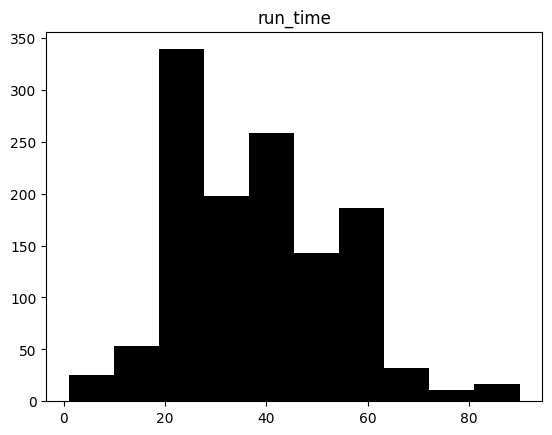

In [32]:
df_serials.hist(column="run_time", color="black", grid=False)

The distribution of the data is less skewed and is more reminiscent of a normal curve. However, it is possible that some genuine run times have been removed. This will be addressed in the next part.

### Subsetting summary
Check the final data frame for this part:

In [33]:
df_serials.head()

,title,start_year,end_year,genre,summary,rating,votes,run_time,actors
0,Masters of the Universe: Revelation,2021,Ongoing,"Animation, Action, Adventure",The war for Eternia begins again in what may b...,5.0,17870,25,"Chris Wood, Sarah Michelle Gellar, Lena Headey..."
1,The Walking Dead,2010,2022,"Drama, Horror, Thriller",Sheriff Deputy Rick Grimes wakes up from a com...,8.2,885805,44,"Andrew Lincoln, Norman Reedus, Melissa McBride..."
2,Rick and Morty,2013,Ongoing,"Animation, Adventure, Comedy",An animated series that follows the exploits o...,9.2,414849,23,"Justin Roiland, Chris Parnell, Spencer Grammer..."
3,Outer Banks,2020,Ongoing,"Action, Crime, Drama",A group of teenagers from the wrong side of th...,7.6,25858,50,"Chase Stokes, Madelyn Cline, Madison Bailey, J..."
4,Dexter,2006,2013,"Crime, Drama, Mystery","By day, mild-mannered Dexter is a blood-spatte...",8.6,665387,53,"Michael C. Hall, Jennifer Carpenter, David Zay..."


In this part the following changes were made:
<ul>
    <li>The scope of the project was narrowed to TV serials.</li>
    <li>Each record could be uniquely identified with the title and <code>start_year</code>.</li>
    <li>Episodes were separated into a new data frame.</li>
    <li>The column <code>director</code> was removed.</li>
    <li>Outliers were removed from the <code>run_time</code> column.</li>
</ul>

Export <code>df_serials</code> data frame as <code>stage3_serials.csv</code> which will be used in the next stage of the project.

In [35]:
df_serials.to_csv("../data/interim/stage3_serials.csv", index=False)

Additionally, we can export the episodes data frame. Although this dataset is missing key information, some of the data, such as the summaries, may be useful for a future project.

In [34]:
df_episodes = df_episodes.sort_values(by=["show", "year"])
df_episodes.to_csv("../data/final/episodes_data.csv", index=False)

### Navigation
**Previous book**: <a href='./02_column_refactor.ipynb'>[Column Refactoring]</a>

**Next book**: <a href='./04_data_enrichment.ipynb'>[ETL & Data Enrichment]</a>